# parPE example: steadystate model - model simulation, optimization, analysis

This notebooks demonstrates basic use of parPE for parameter estimation.

## Prerequisites

This notebook requires:

* a successful *parPE* with CMake options `BUILD_EXAMPLES=ON` (default).
* an installation of the *parPE* Python package (`${PARPE_SOURCE_DIR}/python/`) 
  in the Python environment in which this notebook is run (ideally the `build/venv/` virtual environment)

This notebook assumes that this file is used from its default location and that *parPE* was built inside `${PARPE_SOURCE_DIR}/build/`. If this is not the case, adapt `parpe_source_root` and `parpe_build_root` in the following block correspondingly.

In [1]:
import amici
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
from importlib import reload
import parpe

# set paths
parpe_source_root = os.path.abspath('../../../')
parpe_build_root = os.path.join(parpe_source_root, 'build') 

model_source_dir = f'{parpe_build_root}/examples/parpeamici/steadystate/steadystate_scaled-prefix/src/steadystate_scaled/model_steadystate_scaled'
example_binary_dir = f'{parpe_build_root}/examples/parpeamici/steadystate/'
example_data_dir = f'{parpe_build_root}/examples/parpeamici/steadystate/steadystate_scaled-prefix/src/steadystate_scaled'
optimizationOptionsPy = f'{parpe_source_root}/misc/optimizationOptions.py'

In [2]:
# rebuild example
!cd {parpe_build_root} && make

[  9%] Built target parpecommon
[ 13%] Built target parpeloadbalancer
[ 23%] Built target parpeoptimization
[ 35%] Built target parpeamici
[ 36%] Built target parpe
-- Found Git: /usr/bin/git (found version "2.20.1") 
-- Building version parPE-v0.4.2-12-g8d230-dirty
[ 36%] Built target get_version
[ 42%] Built target unittests_common
[ 47%] Built target unittests_loadbalancer
[ 54%] Built target unittests_optimization
Setting up virtual environment...
[ 54%] Built target setup_venv
[ 55%] Creating test data using hierarchicalOptimizationTest.py
...
----------------------------------------------------------------------
Ran 3 tests in 0.000s

OK
[ 55%] Built target prepare_test_hierarchical_optimization
[ 63%] Built target unittests_amici
[ 65%] Built target example_loadbalancer
[ 76%] Built target steadystate_scaled
[ 79%] Built target example_steadystate_multi_simulator
[ 85%] Built target example_steadystate_parallel
[ 89%] Built target example_steadystate_multi
[ 92%] Built target ex

In [3]:
# run make test to generated all output files required below
!cd {parpe_build_root} && make test

Running tests...
Test project /home/dweindl/src/parPE_2/build
    Start 1: unittests_common
1/7 Test #1: unittests_common .................   Passed    0.32 sec
    Start 2: unittests_loadbalancer
2/7 Test #2: unittests_loadbalancer ...........   Passed    0.01 sec
    Start 3: unittests_optimization
3/7 Test #3: unittests_optimization ...........   Passed    2.16 sec
    Start 4: unittests_amici
4/7 Test #4: unittests_amici ..................   Passed    0.02 sec
    Start 5: example_loadbalancer
5/7 Test #5: example_loadbalancer .............   Passed    0.39 sec
    Start 6: example_steadystate_multi
6/7 Test #6: example_steadystate_multi ........   Passed    8.51 sec
    Start 7: test_steadystate
7/7 Test #7: test_steadystate .................   Passed    0.07 sec

100% tests passed, 0 tests failed out of 7

Total Test time (real) =  11.50 sec


## Model and data

This parameter estimation is specified as set of [PEtab](https://github.com/ICB-DCM/PEtab) files which are generated automatically during the build process (see `${PARPE_SOURCE_ROOT}/examples/parpeamici/steadystate`). They consist of an SBML model and set of tabular files describing model parameters, model inputs and measurements (training data). The model is automatically converted to C++ code and compiled and linked with parPE during the CMake-based build. The data has been converted to a HDF5 parPE input file.

The model is loosely based on an [AMICI](https://github.com/ICB-DCM/AMICI/) example. It describes the dynamics of three species. The model has six outputs with respective measurements. The measurements are based on model simulations to which artifical noise has been added. Data was simulated to represent four different experimental conditions, each with different model inputs. Some outputs represent model states directly, others are offsetted or scaled. For all outputs additive normally distributed noise is assumed, the standard deviation is known for some measurements and is to be estimated for others.

Here we use `libsbml` to show the reactions and species described by the model:

In [4]:
import libsbml
sbml_file = f'{example_data_dir}/model_steadystate_scaled.sbml'
sbml_reader = libsbml.SBMLReader()
sbml_doc = sbml_reader.readSBML(sbml_file)
sbml_model = sbml_doc.getModel()
dir(sbml_doc)

print('Species: ', [s.getId() for s in sbml_model.getListOfSpecies()])

print('\nReactions:')
for reaction in sbml_model.getListOfReactions():
    reactants = ' + '.join(['%s %s'%(int(r.getStoichiometry()) if r.getStoichiometry() > 1 else '', r.getSpecies()) for r in reaction.getListOfReactants()])
    products  = ' + '.join(['%s %s'%(int(r.getStoichiometry()) if r.getStoichiometry() > 1 else '', r.getSpecies()) for r in reaction.getListOfProducts()])
    reversible = '<' if reaction.getReversible() else ''
    print('%3s: %10s %1s->%10s\t\t[%s]' % (reaction.getId(), 
                        reactants,
                        reversible,
                         products,
                        libsbml.formulaToL3String(reaction.getKineticLaw().getMath())))

Species:  ['x1', 'x2', 'x3']

Reactions:
 r1:       2 x1  ->        x2		[p1 * x1^2]
 r2:   x1 +  x2  ->        x3		[p2 * x1 * x2]
 r3:         x2  ->      2 x1		[p3 * x2]
 r4:         x3  ->  x1 +  x2		[p4 * x3]
 r5:         x3  ->          		[k0 * x3]
 r6:             ->        x1		[p5]


### Test simulation

Performing an exemplary model simulation and plotting state and output trajectories:

In [5]:
# load model
sys.path.insert(0, model_source_dir)
import model_steadystate_scaled as modelModule

model = modelModule.getModel()
model.setTimepoints(amici.DoubleVector(np.logspace(-5, 1, 20))) 
solver = model.getSolver()
rdata = amici.runAmiciSimulation(model, solver)

default_parameters = np.array(model.getParameters())

# Default model parameters: print(default_parameters)
# Result fields reported by AMICI: list(rdata.keys())

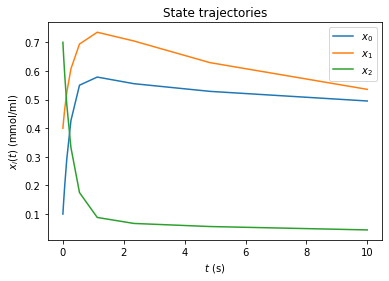

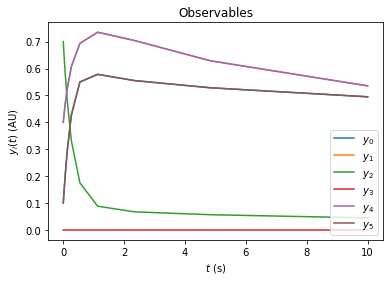

In [6]:
from amici.plotting import plotStateTrajectories
from amici.plotting import plotObservableTrajectories

plotStateTrajectories(rdata)
plotObservableTrajectories(rdata)

## Standard optimization Ipopt

In this section, model parameters are estimated. parPE supports different optimization algorithms, available algorithms depend on the build configuration. In this section we will use Ipopt, which worked the best in our experience (https://www.biorxiv.org/content/early/2018/01/15/247924).

Based on the parPE template files, a exectuable for parameter estimation has been built. By default these executables are named `estimate_${MODEL_NAME}`. These files require a HDF5 file containing training data and optimization options. All those files have been generated automatically for this example.

This part of the example requires a parPE build with `PARPE_ENABLE_IPOPT=ON`.

### Set parameter estimation options

Parameter estimation settings specified inside an HDF5 file. Those can be changed from any programming language with HDF5 bindings, with hdfview (https://www.hdfgroup.org/downloads/hdfview/), or with a helper script included in parPE, as demonstrated here:

In [7]:
# enable derivate checker
input_file = f'{example_data_dir}/example_data.h5'

#!{optimizationOptionsPy} {input_file} -s ipopt/derivative_test first-order
#!{optimizationOptionsPy} {input_file} -s ipopt/derivative_test_print_all yes

# Use Ipopt
!{optimizationOptionsPy} {input_file} -s optimizer 0

# Perform one optimizer runs from different starting points
!{optimizationOptionsPy} {input_file} -s numStarts 1

# Run for 20 iterations
!{optimizationOptionsPy} {input_file} -s ipopt/max_iter 20

# Disable hierarchical optimization (see below)
!{optimizationOptionsPy} {input_file} -s hierarchicalOptimization 0

# Print settings
!{optimizationOptionsPy} {input_file}

                hierarchicalOptimization            0
                               numStarts            1
                               optimizer            0
                       retryOptimization            1
                ceres/max_num_iterations          100
                         fmincon/GradObj        b'on'
                     fmincon/MaxFunEvals   10000000.0
                         fmincon/MaxIter          100
                          fmincon/TolFun            0
                            fmincon/TolX        1e-08
                       fmincon/algorithm b'interior-point'
                         fmincon/display      b'iter'
                   ipopt/acceptable_iter            1
         ipopt/acceptable_obj_change_tol        1e-12
                    ipopt/acceptable_tol        1e+20
             ipopt/hessian_approximation b'limited-memory'
        ipopt/limited_memory_update_type      b'bfgs'
                          ipopt/max_iter           20
                  

### Gradient check

Before starting the optimization, we can shortly compare the objective function gradients computed by AMICI/parPE with finite differences:

In [8]:
# use three random starting points:
for i in range(3):
    !PARPE_NO_DEBUG=1 {example_binary_dir}/example_steadystate_multi -t gradient_check -o deletemegc/ {input_file}
    print()


[2020-01-31 18:27:42] [INF] [-1/]     0 g: -1.25564e+12  fd_c: -1.25588e+12  Δ/ff: 1.060476e-05  f:   2.2618e+13
[2020-01-31 18:27:42] [INF] [-1/]     1 g: -3.95647e+10  fd_c: -3.96655e+10  Δ/ff: 4.456608e-06  f:   2.2618e+13
[2020-01-31 18:27:42] [INF] [-1/]     2 g:  3.95672e+10  fd_c:  3.93782e+10  Δ/ff: 8.357255e-06  f:   2.2618e+13
[2020-01-31 18:27:42] [INF] [-1/]     3 g:  2.96427e+10  fd_c:   2.9551e+10  Δ/ff: 4.053743e-06  f:   2.2618e+13
[2020-01-31 18:27:42] [INF] [-1/]     4 g:  1.59802e+12  fd_c:  1.59777e+12  Δ/ff: 1.114006e-05  f:   2.2618e+13
[2020-01-31 18:27:42] [INF] [-1/]     5 g:  1.38876e+10  fd_c:  1.38876e+10  Δ/ff: -1.304981e-11  f:   2.2618e+13
[2020-01-31 18:27:42] [INF] [-1/]     6 g:  1.59715e+08  fd_c:  1.59715e+08  Δ/ff: 1.536720e-12  f:   2.2618e+13
[2020-01-31 18:27:42] [INF] [-1/]     7 g: -2.87507e+12  fd_c: -2.87507e+12  Δ/ff: 5.650279e-11  f:   2.2618e+13
[2020-01-31 18:27:42] [INF] [-1/]     8 g:  3.87833e+08  fd_c:  3.87833e+08  Δ/ff: -5.849452e-1

### Optimize

Now we can run the actual optimization.

In [9]:
# !(cd {parpe_build_root} && exec make -j12) # rebuild
!rm -rf deleteme # delete old result files 

# optimize (using a single process)
!PARPE_NO_DEBUG=1 {example_binary_dir}/example_steadystate_multi -o deleteme/ {example_data_dir}/example_data.h5


[2020-01-31 18:27:43] [INF] [-1/] Reading random initial theta 0 from /optimizationOptions/randomStarts

List of user-set options:

                                    Name   Value                used
                         acceptable_iter = 1                     yes
               acceptable_obj_change_tol = 1e-12                 yes
                          acceptable_tol = 1e+20                 yes
                   hessian_approximation = limited-memory        yes
              limited_memory_update_type = bfgs                  yes
                                max_iter = 20                    yes
                             print_level = 5                     yes
                      print_user_options = yes                   yes
                                     tol = 1e-09                 yes
         watchdog_shortened_iter_trigger = 0                     yes

******************************************************************************
This program contains Ipopt, 

[2020-01-31 18:27:46] [INF] [-1/] Walltime on master: 3.009616s, CPU time of all processes: 8.022685s


### Analyze results

A good start for checking the results is a look at optimizer trajectories. This can be easily done using the *parPE* Python package: 

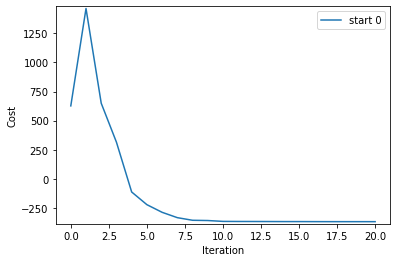

In [10]:
filename = 'deleteme/_rank00000.h5'
trajectories_ipopt = parpe.getCostTrajectories(filename)
#print(repr(trajectories))
parpe.plotting.plotCostTrajectory(trajectories_ipopt, log=False);

Since this example uses artificial data based on model simulations with known parameters, we can compare them to the optimization results:

In [11]:
parpe.compare_optimization_results_to_true_parameters('deleteme/_rank00000.h5')

#  __Exp____ __Act______ __Err______ __RelErr___ __ID_______
0:   1.00000     2.02746     1.02746     1.02746 p1
1:   0.50000     0.58197     0.08197     0.16394 p2
2:   0.40000     0.79902     0.39902     0.99756 p3
3:   2.00000     2.07928     0.07928     0.03964 p4
4:   0.10000     0.11157     0.01157     0.11573 p5
5:   2.00000     0.02880    -1.97120    -0.98560 scaling_x1_common
6:   3.00000     3.03039     0.03039     0.01013 offset_x2_batch-0
7:   0.20000     0.18353    -0.01647    -0.08234 x1withsigma_sigma
8:   4.00000     4.01172     0.01172     0.00293 offset_x2_batch-1

Status: 1
Cost: -368.587402 (expected: -0.000000)


The parameters don't match that greatly. This is not completely unexpected due to the artificial noise introduced. To get a closer look at the optiization result, we can compare the training data to the model output with the optimized parameters.

The model outputs are by default not saved during optimization, because this can lead to much I/O overhead and large files. However, there is an executable to quickly rerun simulation with the optimal parameters:

In [12]:
# Simulate with optimal parameters, save results
!rm -f sim.h5 # remove files from previous run
!{example_binary_dir}/example_steadystate_multi_simulator deleteme/_rank00000.h5 / sim.h5 / --at-optimum --nompi

Running for start 0
HierarchicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
Need to compute analytical parameters: //inputData  1 parameters.size() == 5 ; hierarchical.numParameters() == 5
Starting simulation. Number of conditions: 4


In [13]:
# Load simulated outputs
(measured, simulated, timepoints, llh) = parpe.readSimulationsFromFile('simh.h5')
start_idx = '0'

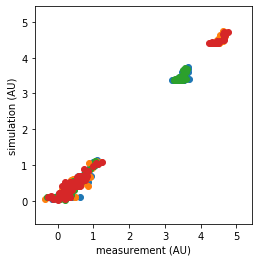

In [14]:
# Plot correlation of measurements (training data) and model simulation with optimized parameters 
parpe.plotting.plotCorrelation(measured[start_idx], simulated[start_idx])

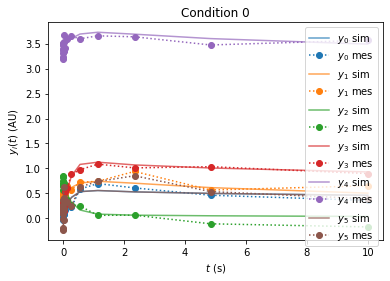

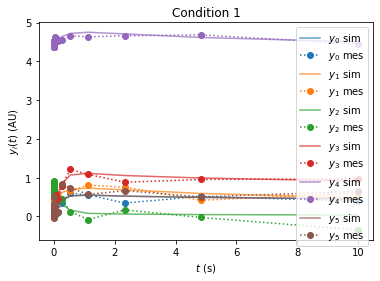

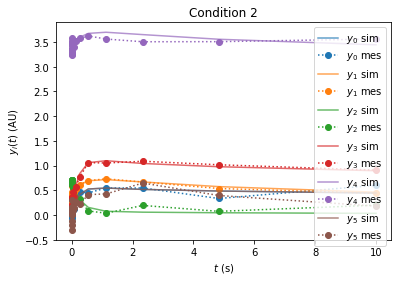

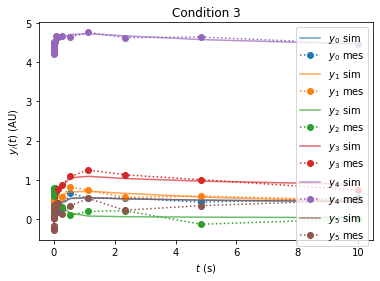

In [15]:
# Plot measurement trajectories (training data) and compare to model simulation with optimized parameters
parpe.plotting.plotTrajectoryFits(measured[start_idx], simulated[start_idx], timepoints[start_idx])

## Changing optimizers - Ceres

Once parPE has been built with support for different optimizers, selecting a different optimizer is quite easy. 

(This part of the example requires a parPE build with `PARPE_ENABLE_CERES=ON`)

In [16]:
# copy input file from above example
example_data_ceres = f'{example_data_dir}/example_data_ceres.h5'
!cp {example_data_dir}/example_data.h5 {example_data_ceres}

# Change optimizer to CERES
# NOTE: For this moment, optimizers are inconveniently selected based on numeric values, 0 is Ipopt, 1 is Ceres.
!{optimizationOptionsPy} {example_data_ceres} -s optimizer 1

# Run optimization
!PARPE_NO_DEBUG=1 mpiexec -n 4 {example_binary_dir}/example_steadystate_multi  -o deletemeceres/ {example_data_ceres} --mpi

[2020-01-31 18:27:49] [INF] [0/dweindl-ThinkPad-L480] Running with 4 MPI processes.
[2020-01-31 18:27:49] [INF] [0/dweindl-ThinkPad-L480] Reading random initial theta 0 from /optimizationOptions/randomStarts
[2020-01-31 18:27:49] [INF] [0/dweindl-ThinkPad-L480] [o0i0] iter: 0 cost: 626.531 time_iter: wall: 0.0878097s cpu: 0.215641s time_optim: wall: 0.08781s cpu: 0.215641s
[2020-01-31 18:27:49] [INF] [0/dweindl-ThinkPad-L480] [o0i1] iter: 1 cost: -282.389 time_iter: wall: 0.0382636s cpu: 0.0854241s time_optim: wall: 0.126074s cpu: 0.301066s
[2020-01-31 18:27:49] [INF] [0/dweindl-ThinkPad-L480] [o0i2] iter: 2 cost: -312.328 time_iter: wall: 0.0944906s cpu: 0.175008s time_optim: wall: 0.220565s cpu: 0.476073s
[2020-01-31 18:27:49] [INF] [0/dweindl-ThinkPad-L480] [o0i3] iter: 3 cost: -327.5 time_iter: wall: 0.0798723s cpu: 0.155348s time_optim: wall: 0.300437s cpu: 0.631422s
[2020-01-31 18:27:49] [INF] [0/dweindl-ThinkPad-L480] [o0i4] iter: 4 cost: -329.721 time_iter: wall: 0.0788383s cpu

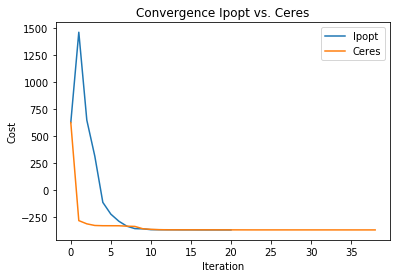

In [17]:
ceres_optimization_result_filename = 'deletemeceres/_rank00000.h5'
trajectories_ceres = parpe.getCostTrajectories(ceres_optimization_result_filename)
#print(repr(trajectories))
ax = parpe.plotting.plotCostTrajectory(trajectories_ipopt, log=False);
parpe.plotting.plotCostTrajectory(trajectories_ceres, log=False, ax=ax);
ax.autoscale(True)
ax.legend(['Ipopt', 'Ceres'])
ax.set_title('Convergence Ipopt vs. Ceres');

In [18]:
parpe.compare_optimization_results_to_true_parameters(ceres_optimization_result_filename)

#  __Exp____ __Act______ __Err______ __RelErr___ __ID_______
0:   1.00000     1.79204     0.79204     0.79204 p1
1:   0.50000     0.59116     0.09116     0.18231 p2
2:   0.40000     0.70481     0.30481     0.76204 p3
3:   2.00000     2.10835     0.10835     0.05417 p4
4:   0.10000     0.11230     0.01230     0.12300 p5
5:   2.00000     0.02749    -1.97251    -0.98626 scaling_x1_common
6:   3.00000     3.02899     0.02899     0.00966 offset_x2_batch-0
7:   0.20000     0.18342    -0.01658    -0.08292 x1withsigma_sigma
8:   4.00000     4.01287     0.01287     0.00322 offset_x2_batch-1

Status: 0
Cost: -368.648089 (expected: -0.000000)
